In [1]:
import matplotlib.pyplot as plt
import torch

from src import read_dicom, Detector, Siddon

device = torch.device("cuda:0")

In [2]:
def get_detector(source, center, height=101, delx=4.):
    
    detector = Detector(
        source=source,
        center=center,
        height=height,
        width=height,
        delx=delx,
        dely=delx,
        device=device
    )

    source = detector.source
    rays = detector.make_xrays()
    
    return source, rays

In [3]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr/")
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

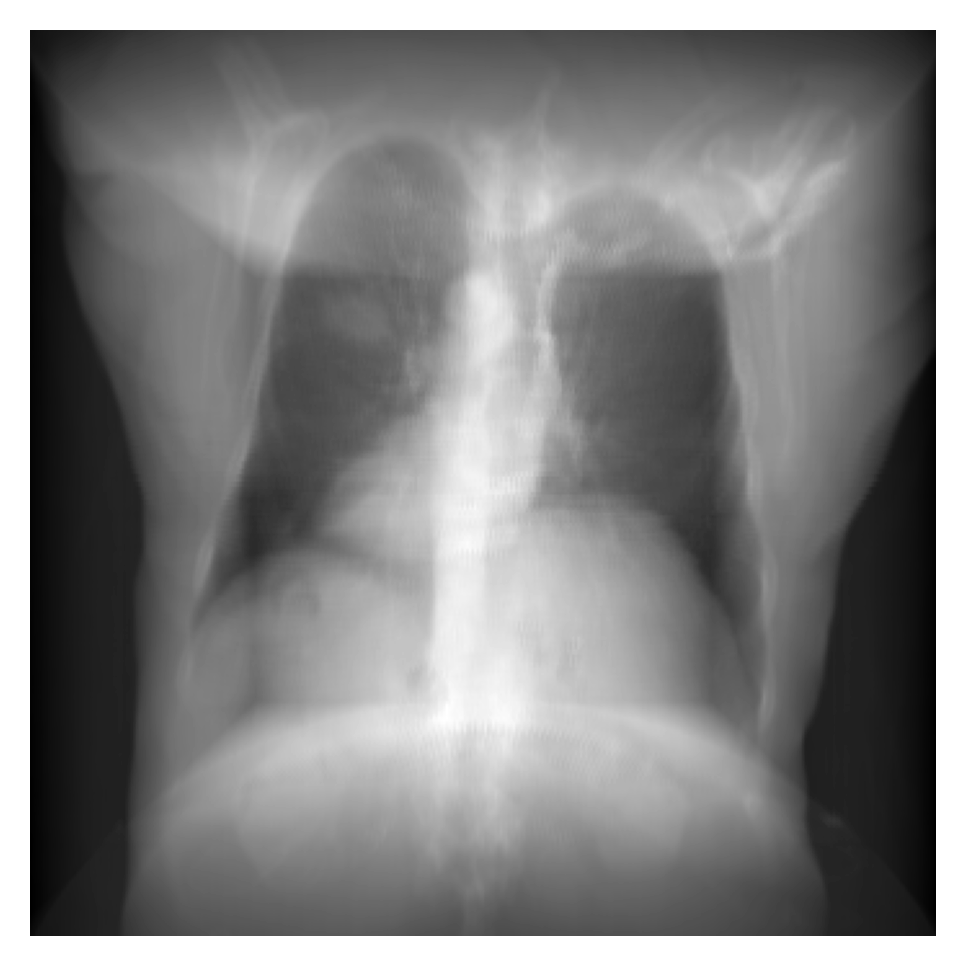

In [4]:
source, rays = get_detector([-100., 180.1, 161.], [1500., 180., 160.], height=351, delx=10.)
drr = siddon.raytrace(source, rays)

fig, ax = plt.subplots(dpi=300)
ax.imshow(drr.detach().cpu(), cmap="gray")
ax.axis("off")

plt.savefig("../figures/example_DRR.pdf")
plt.show()